In [51]:
import torch
import torch.autograd as autograd         # computation graph
import torch.nn as nn                     # neural networks

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import time

import plotly.graph_objects as go

# Ecuación de Burger
Sea $\Omega = [-1,1]\times [0,1]$. Determinar $u(t,x)$ que satisfaga: 

1. $$u_t + uu_x - (0.01/\pi)u_{xx} = 0 \hspace{0.8cm}  \text{En el interior de } \Omega$$

2. $$u(0,x) = -\sin(\pi x ) $$

3. $$u(t,-1) = u(t,1) = 0 $$

## Enfoque PINNs 
Considere los siguientes conjuntos de puntos:

$\{x_j^{e}, t_j^{e}\}_{j=1}^{N_e}$ un conjunto de puntos en el interior de $\Omega$.

$\{x_j^{1}, t_j^{1}\}_{j=1}^{N_1}$ un conjunto de puntos en $\{1\}\times[0,1]$. 

$\{x_j^{2}, t_j^{2}\}_{j=1}^{N_2}$ un conjunto de puntos en $\{-1\}\times[0,1]$.

$\{x_j^{i}, t_j^{i}\}_{j=1}^{N_i}$ un conjunto de puntos en $[-1,1]\times \{0\}$.



Sea $\hat{u}(x,t; \vec{\theta})$ una red neuronal feed-forward con dos neuronas de entradas, una neurana de salida, con $l$ capas ocultas de $l_n$ neuronas para cada capa oculta. El enfoque PINNs sostiene que la solución del problema 1-2-3 se reduce a determinar los pesos y sesgos (vector $\vec{\theta}$) de la red $\hat{u}$ que minimiza la siguiente función de pérdida:

$$\mathcal{L}(\vec{\theta}) =  \mathcal{L}_r(\vec{\theta}) + \mathcal{L}_{r_1}(\vec{\theta}) + \mathcal{L}_{r_2}(\vec{\theta}) + \mathcal{L}_{r_i}(\vec{\theta})$$


donde 

$$\mathcal{L}_r(\vec{\theta}) = \dfrac{1}{N_i}\sum_{n = 1}^{N_i} \left(\hat{u}_t(x_n^{e}, t_n^{e})  + \hat{u}(x_n^{e}, t_n^{e}) \hat{u}_x(x_n^{e}, t_n^{e})  - (0.001 / \pi)\hat{u}_{xx}(x_n^{e}, t_n^{e}) \right)^2,$$

$$\mathcal{L}_{r_1}(\vec{\theta}) = \dfrac{1}{N_1}\sum_{n = 1}^{N_1}  \left(\hat{u}(x_n^{1}, t_n^{1}) - 0  \right)^2,$$

$$\mathcal{L}_{r_2}(\vec{\theta}) = \dfrac{1}{N_2}\sum_{n = 1}^{N_2}  \left(\hat{u}(x_n^{2}, t_n^{2}) - 0  \right)^2,$$

$$\mathcal{L}_{inicial}(\vec{\theta}) = \dfrac{1}{N_i}\sum_{n = 1}^{N_i}  \left(\hat{u}(x_n^{i}, t_n^{i}) - [-\sin(\pi x_n^{i})] \right)^2.$$


## Funciones Auxiliares 

In [35]:
#Graficos 3D
def plot3D_Matrix(x,t,y):
    X,T= x,t
    F_xt = y
    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('u(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    ax.plot_surface(T, X, F_xt,cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u(x,t)')
    plt.show()

In [36]:
def super_plot(x,t,y):
    x_ = x
    t_ = t
    u_ = y
    fig = go.Figure(data=[go.Surface(z=u_, x=x_, y=t_)])
    fig.update_layout(title='Prediction PINNs', 
                  autosize=False, width=700, height=700,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
            xaxis_title='Eje x ',  # Etiqueta del eje X
            yaxis_title='Eje t ',    # Etiqueta del eje Y
            zaxis_title='Eje z '   # Etiqueta del eje Z
                  ))
    fig.show()

## Clase BurgerNet

In [79]:
class Burger_Net(nn.Module):
    def __init__(self, num_layers = 8):
        super(Burger_Net, self).__init__()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.num_layers = num_layers
        layers = []
        input_dim = 2
        hidden_dim = 20
        output_dim = 1

        # Añadir la primera capa que conecta la entrada con la primera capa oculta
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())

        # Usar un bucle para añadir las capas ocultas intermedias
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())

        # Añadir la capa de salida
        layers.append(nn.Linear(hidden_dim, output_dim))

        # Crear la secuencia de capas
        self.hidden_layers = nn.Sequential(*layers)

        #diffusion coeficient
        self.nu = 0.01/np.pi 

        self.iter = 0

    def forward(self, x, t):
        #x = x.view(-1, 1)
        #y = y.view(-1, 1)
        xy = torch.cat([x, t], dim=1)
        T = self.hidden_layers(xy)
        return T   

    def loss_BC(self, x, t, y):
        loss_bc = self.loss_function(self.forward(x,t), y)
        return loss_bc

    def loss_IC(self, x, t, y):
        loss_ic = self.loss_function(self.forward(x,t), y)
        return loss_ic

    def loss_PDE(self, x, t):
        u = self.forward(x, t)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        f = u_t + u * u_x - self.nu * u_xx
        f_hat = torch.zeros(x.shape[0],1)
        loss_f = self.loss_function(f, f_hat)
        return loss_f

    def loss(self, x_c, t_c, x_i, t_i, u_i, x_b_1, t_b_1, u_b_1, x_b_2, t_b_2, u_b_2):
        loss_bc_1 = self.loss_BC(x_b_1, t_b_1, u_b_1)
        loss_bc_2 = self.loss_BC(x_b_2, t_b_2, u_b_2)
        loss_ic = self.loss_IC(x_i, t_i, u_i)
        loss_pde = self.loss_PDE(x_c, t_c)
        loss = loss_bc_1 + loss_bc_2 + loss_ic + loss_pde
        return loss

        
    def closure(self):
        optimizer.zero_grad()  # Limpia los gradientes anteriores
        loss = self.loss(x_data, t_data, x_init, t_init, u_init, x_bound_1, t_bound, u_bound, x_bound_2, t_bound, u_bound)
        loss.backward()  # Calcula nuevos gradientes
        losses.append(loss.item())
        
        self.iter +=1

        if self.iter % 500 == 0:
            print(f"Epoch {self.iter}: Loss {loss.item()}")
        
        return loss    

## Generación de Dominio

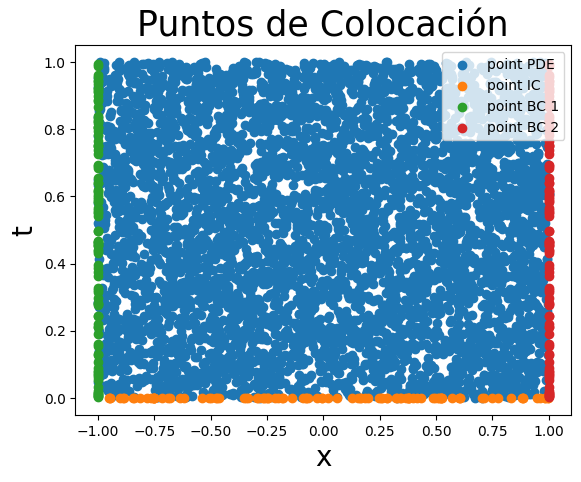

In [80]:
# Generation Data
x_min = -1.0
x_max = 1.0
t_min = 0.0
t_max = 1.0

# Points PDE
N_f = 5000
#x_data, t_data = np.meshgrid(np.linspace(x_min, x_max, N_f), np.linspace(t_min, t_max, N_f))
#x_data, t_data = torch.tensor(x_data.flatten(), requires_grad=True).float().view(-1, 1), torch.tensor(t_data.flatten(), requires_grad= True).float().view(-1, 1)
x_data = (torch.rand(N_f) * (x_max - x_min) + x_min).float().view(-1,1)
t_data = (torch.rand(N_f) * (t_max - t_min) + t_min).float().view(-1,1)
x_data.requires_grad = True
t_data.requires_grad = True


# Initial Condition
N_u = 100
x_init = (torch.rand(N_u) * (x_max - x_min) + x_min).float().view(-1,1)
t_init = torch.zeros(N_u, 1)
u_init = -1.0 * torch.sin(np.pi * x_init)

# Boundary Condition
N_u = 100
x_bound_1 = -1.0 * torch.ones(N_u, 1)
x_bound_2 =  1.0 * torch.ones(N_u, 1)
t_bound = (torch.rand(N_u) * (t_max - t_min) + t_min).float().view(-1,1)
u_bound = torch.zeros(N_u, 1)

# Puntos de entrenamiento
plt.scatter(x_data.detach().numpy(), t_data.detach().numpy(), label = 'point PDE')
plt.scatter(x_init.detach().numpy(), t_init.detach().numpy(), label = 'point IC')
plt.scatter(x_bound_1.detach().numpy(), t_bound.detach().numpy(), label = 'point BC 1')
plt.scatter(x_bound_2.detach().numpy(), t_bound.detach().numpy(), label = 'point BC 2')
plt.title('Puntos de Colocación', fontsize = 25)
plt.xlabel('x', fontsize = 20)
plt.ylabel('t', fontsize = 20)
plt.legend()
plt.show()

## Entrenamiento

In [81]:
# Instanciar el modelo
Net = Burger_Net()

In [82]:
# Definir el Optimizador
optimizer = torch.optim.Adam(Net.parameters(), lr=0.001)


In [83]:
losses = [] 

In [84]:
# Training loop 
for pinn_epoch in tqdm(range(5000), desc='PINN training progress'):
    optimizer.zero_grad()
    loss = Net.loss(x_data, t_data, x_init, t_init, u_init, x_bound_1, t_bound, u_bound, x_bound_2, t_bound, u_bound)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if pinn_epoch % 500 == 0:
        print(f'Epoch {pinn_epoch}, loss {loss.item()}')

PINN training progress:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0, loss 0.5895913243293762
Epoch 500, loss 0.06783774495124817
Epoch 1000, loss 0.017242642119526863
Epoch 1500, loss 0.007760814391076565
Epoch 2000, loss 0.00486674252897501
Epoch 2500, loss 0.004312716890126467
Epoch 3000, loss 0.004290453623980284
Epoch 3500, loss 0.0028098521288484335
Epoch 4000, loss 0.002352166920900345
Epoch 4500, loss 0.002110633533447981


In [85]:
# L-BFGS Optimizer
steps = 10000
optimizer = torch.optim.LBFGS(Net.parameters(), lr=0.1,
                              max_iter = steps,
                              max_eval = None,
                              tolerance_grad = 1e-11,
                              tolerance_change = 1e-11,
                              history_size = 100,
                              line_search_fn = 'strong_wolfe')

# Optimización 
start_time = time.time()

optimizer.step(Net.closure)

elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

Epoch 500: Loss 0.0005568930646404624
Epoch 1000: Loss 0.00023464144032914191
Epoch 1500: Loss 0.00013057647447567433
Epoch 2000: Loss 7.679869304411113e-05
Epoch 2500: Loss 4.87039505969733e-05
Epoch 3000: Loss 3.3788615837693214e-05
Epoch 3500: Loss 2.2168354917084798e-05
Epoch 4000: Loss 1.3547624803322833e-05
Epoch 4500: Loss 9.861233593255747e-06
Epoch 5000: Loss 7.856227966840379e-06
Training time: 153.03


## Resultados

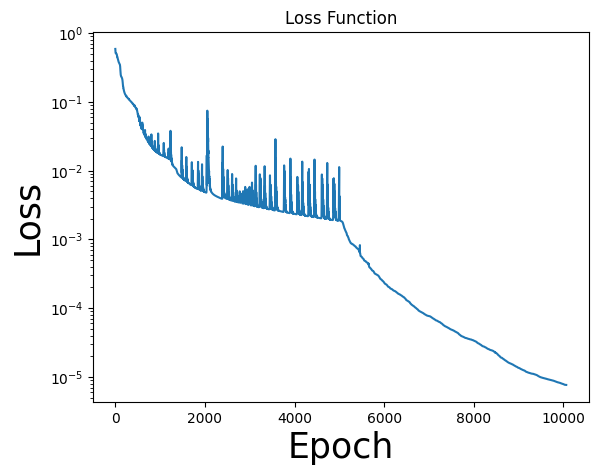

In [86]:
# Grafica Loss
plt.plot(losses)
plt.title('Loss Function')
plt.yscale('log')
plt.ylabel('Loss', fontsize = 25)
plt.xlabel('Epoch', fontsize = 25)
plt.show()

In [87]:
# plot prediccion
N_t = 100
x_test, t_test = np.meshgrid(np.linspace(x_min, x_max, N_t), np.linspace(t_min, t_max, N_t))
x_test_ = torch.tensor(x_test.flatten()).clone().detach().view(-1, 1).float()
t_test_ = torch.tensor(t_test.flatten()).clone().detach().view(-1, 1).float()

u_pred = Net(x_test_, t_test_).detach().numpy().reshape(N_t, N_t)

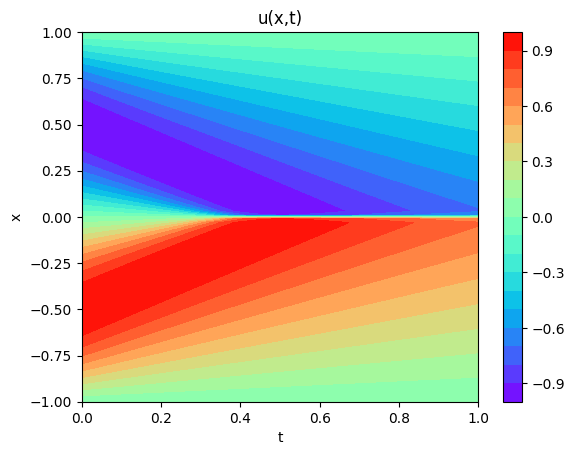

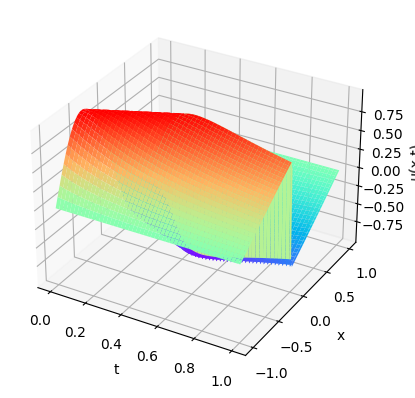

In [88]:
plot3D_Matrix(x_test,t_test,u_pred)

In [89]:
super_plot(x_test,t_test,u_pred)